In [16]:
### PYMOO
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination

#multiprocessamento e outros
from tqdm.notebook import trange, tqdm
import multiprocessing, requests, sys, time, itertools, dill, random, os, pickle, copy

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Goatools e Gontosim
from goatools.obo_parser import GODag
from goatools.base import get_godag
#go = get_godag("go-basic.obo", optional_attrs={'relationship'})
from Similarity import Similarity_of_Two_GOTerms, Similarity_of_Set_of_GOTerms

""" Funções e Variaveis Auxiliares"""
MAX_FEATURES = 100
from PlotingFunctions import *

### Importação dos dados

In [7]:
data = pd.read_pickle('Data/data_Breast_GSE70947_norm.pkl')
colunas = data.columns.drop(['type']).tolist()

affymetrix_similarity = pd.read_pickle('./Data/Breast_GSE70947-gene_symbols.pkl')
go_completeness = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores']))
go_completeness_breast_cancer = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores_breast_cancer_pathways']))
del go_completeness['type']
del go_completeness_breast_cancer['type']
X = data[colunas]
y = data['type']

#matrix_similarity = np.load('Data/matrix_go_terms_sets.npy') ## Remover um dia

In [8]:
for i in go_completeness.keys():
    if go_completeness[i] != 1:
       go_completeness[i] = 0.0

for i in go_completeness_breast_cancer.keys():
    if go_completeness_breast_cancer[i] != 1:
       go_completeness_breast_cancer[i] = 0.0

### Função de avaliação

In [9]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						n_constr=0,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
    	# seleciona as features de acordo com o vetor binário
        selected_features = np.where(x == 1)[-1]
        X_selected = X_worker[:,selected_features]
        f_1 = []
        n_tests = 5
        seed = 41
        for i in range(n_tests):
            seed = seed + 1
            # Kfolding usado para separar em treino e teste
            skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
            #X_train, X_valid, y_train, y_valid = train_test_split(X_selected, self.y, test_size=0.1, random_state=100)
        	
        	# treino usando modelo SVM
            clf = svm.SVC(kernel='linear')
    
            # compute f_1 and AUC on validation set
            f_1.append(np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro')))
        
        f_1 = round(np.array(f_1).sum()/n_tests, 3)
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
    	# define os objetivos a serem minimizados
        out["F"] = [n_features, -f_1]

### Sampling Customizado

In [38]:
class BinaryDistributedRandomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.array([True] * trues + [False] * (problem.n_var - trues))
            np.random.shuffle(individual)
            population.append(individual)
        #print(population)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

class BinaryDistributedPathwaysSampling(Sampling):
    def __init__(self, **kwargs):
        self.go_completeness = kwargs.pop('go_completeness', None)
        super().__init__(**kwargs)
    def _do(self, problem, n_samples, **kwargs):
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.full(len(colunas), False)
            individual[random.choices(range(len(colunas)), weights=self.go_completeness, k=trues)] = True
            population.append(individual)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

class BinaryDistributedRandomSamplingFilter(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        population = []
        filter = SelectKBest(f_classif, k=1000).fit(X, y)
        features_filter = filter.get_feature_names_out()
        possible_indexes = [colunas.index(item) for item in features_filter]
        print(possible_indexes)
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            indexes = np.random.choice(possible_indexes, trues, replace=False)
            individual = np.full(problem.n_var, False)
            individual[indexes] = True
            population.append(individual)
            #print(trues)
            #print(sorted(indexes))
            #print(individual)
        #print(population)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

In [ ]:
'''
X = np.full(X.shape, True)
prob_var = 0.1
full = np.random.rand(*X.shape) < prob_var  # Evita uma criação redundante de matriz e faz o flip diretamente

# Itera diretamente em X e full para alterar os valores
for individual, vector in zip(tqdm(X), full):
    num_changes = min(MAX_FEATURES, np.sum(vector))  # Limita a quantidade de alterações pelo MAX_FEATURES
    true_indices = np.where(individual)[0]
    false_indices = np.where(~individual)[0]

    # Seleciona índices aleatórios para trocar, dividindo o número de mudanças igualmente entre 'True' e 'False'
    flip_choices = np.random.rand(num_changes) < 0.5
    true_flips = np.sum(flip_choices)
    false_flips = num_changes - true_flips

    if true_flips > 0 and len(true_indices) > 0:
        individual[np.random.choice(true_indices, min(true_flips, len(true_indices)), replace=False)] = False
    if false_flips > 0 and len(false_indices) > 0:
        individual[np.random.choice(false_indices, min(false_flips, len(false_indices)), replace=False)] = True

for individual in tqdm(X):
    if individual.sum() == 0:
        individual[np.random.choice(range(len(individual)))] = True
    while individual.sum() > MAX_FEATURES:
        individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
'''

In [ ]:
trues = 10
individual = np.full(len(colunas[:500]), False)
individual[random.choices(range(len(colunas[:500])), weights=list(go_completeness.values())[:500], k=trues)] = True

np.array(range(len(individual)))[individual]

In [ ]:
random.choices(, k = 1, weights = list(go_completeness.values()))

In [ ]:
np.array(list(go_completeness.values()))[np.where(np.array(list(go_completeness.values())))]

### Mutações customizadas

In [11]:
class BitflipMutationLimited(Mutation):
    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual[np.random.choice(range(len(individual)))] = False
        return Xp

class BitflipMutationLimitedBalanced(Mutation):
    def __init__(self, **kwargs):
        self.go_completeness = kwargs.pop('go_completeness', None)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        full = np.random.rand(*X.shape) < prob_var  # Evita uma criação redundante de matriz e faz o flip diretamente

        # Itera diretamente em X e full para alterar os valores
        for individual, vector in zip(X, full):
            num_changes = min(MAX_FEATURES, np.sum(vector))  # Limita a quantidade de alterações pelo MAX_FEATURES
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            # Seleciona índices aleatórios para trocar, dividindo o número de mudanças igualmente entre 'True' e 'False'
            flip_choices = np.random.rand(num_changes) < 0.5
            true_flips = np.sum(flip_choices)
            false_flips = num_changes - true_flips

            if self.go_completeness is not None:
                weights = self.go_completeness[false_indices]
            else:
                weights = None
            
            if true_flips > 0 and len(true_indices) > 0:
                individual[np.random.choice(true_indices, min(true_flips, len(true_indices)), replace=False)] = False
            if false_flips > 0 and len(false_indices) > 0:
                individual[random.choices(false_indices, k = min(false_flips, len(false_indices)), weights=weights)] = True
                #individual[np.random.choice(false_indices, min(false_flips, len(false_indices)), replace=False)] = True

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        return X
'''
def return_score(gen1, gen2):
    if len(gen1) == 0 or len(gen2) == 0:
        return 0
    if len(gen1) > 100:
        gen1 = np.random.choice(gen1, 100)
    if len(gen2) > 10:
        gen2 = np.random.choice(gen2, 10)
    return Similarity_of_Set_of_GOTerms(gen1, gen2, 'GOGO')
'''
def getSimilarityofAffymetrix(aff1, aff2, affymetryx_to_go, matrix_similarity, go_sets_labels):
    gen1 = []
    gen2 = []
    for aff in aff1:
        gen1.append(affymetrix_GO_terms_dict[aff])

    gen2 = affymetrix_GO_terms_dict[aff2]
    score = 0
    for gen_subset in gen1:
            score += getSimilarityofSetofGOTerms(gen_subset, gen2, matrix_similarity, go_sets_labels)/len(gen1)
    return score

def getSimilarityofSetofGOTerms(gen1, gen2, matrix_similarity, labels):
    return matrix_similarity[labels[tuple(gen1)]][[labels[tuple(gen2)]]][0]
    
def mutateIndividual(individual, past_individual, n_mutations):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        max_score = 0
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            final_candidate = candidate
            affymetrix_candidate = colunas_worker[candidate]
            score = getSimilarityofAffymetrix(affymetrix_individual, affymetrix_candidate, affymetrix_GO_terms_dict, matrix_similarity_worker, go_sets_labels_worker)
            if max_score < score:
                final_candidate = candidate
                max_score = score
        
        individual[final_candidate] = True  
    return individual

def mutateIndividualFuzzy(individual, past_individual, n_mutations, exploratory):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        candidates = []
        candidates_scores = []
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            candidates.append(candidate)
            affymetrix_candidate = colunas_worker[candidate]
            score = getSimilarityofAffymetrix(affymetrix_individual, affymetrix_candidate, affymetrix_GO_terms_dict, matrix_similarity_worker, go_sets_labels_worker)
            candidates_scores.append(score)
            
        candidates_scores = np.array(candidates_scores) + 0.01
        if exploratory:
            candidates_scores = [1 for score in candidates_scores]
        #print(candidates_scores)
        final_candidate = random.choices(candidates, weights=candidates_scores, k=1)
        individual[final_candidate] = True  
    return individual

def mutateIndividualFuzzyPathways(individual, past_individual, n_mutations, exploratory, go_completeness):
    added = individual & ~past_individual
    total_added = added.sum()
    individual[added] = False
    affymetrix_individual = np.array(colunas_worker)[individual]
    
    for i in range(added.sum()):
        candidates = []
        candidates_scores = []
        for i in range(n_mutations):
            candidate = np.random.choice(np.array(range(len(individual)))[~individual])
            candidates.append(candidate)
            score = list(go_completeness.values())[candidate]
            candidates_scores.append(score)
            
        candidates_scores = np.array(candidates_scores) + 0.2
        #if exploratory:
        #    candidates_scores = [1 for score in candidates_scores]
        #print(candidates_scores)
        final_candidate = random.choices(candidates, weights=candidates_scores, k=1)
        individual[final_candidate] = True  
    return individual

class BitflipMutationLimitedGuided(Mutation):
    def __init__(self, **kwargs):
        self.go_completeness = kwargs.pop('go_completeness', None)
        super().__init__(**kwargs)
        self.steps = 0

    def _do(self, problem, X, **kwargs):
        self.steps += 1
        #print(self.steps)
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]

        algorithm = kwargs['algorithm']
        #if algorithm.n_gen > (algorithm.termination.n_max_gen/2):
            #print('aahh')
            #Xp = np.array([mutate_individual(xi[0], xi[1]) for xi in zip(Xp, X)])
        exploratory = random.choice([True, True])
        Xp = np.array(mutation_pool.starmap(mutateIndividualFuzzyPathways, zip(Xp, X, itertools.repeat(20), itertools.repeat(exploratory), itertools.repeat(self.go_completeness))))
            #print('Tempo:', time.time() - start)        
            #for individual, past_individual in zip (Xp, X):
            #    individual = mutate_individual(individual, past_individual)
                
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual[np.random.choice(range(len(individual)))] = False
        return Xp

### Init Workers

In [12]:
def _init_evaluator():
    global pid_, X_worker, y_worker, colunas_worker
    pid_ = os.getpid()
    X_worker = np.array(X.copy())
    y_worker = np.array(y.copy())
    colunas_worker = colunas.copy()
def _init_mutator():
    global pid_, colunas_worker, matrix_similarity_worker, go_sets_labels_worker
    pid_ = os.getpid()
    colunas_worker = colunas.copy()
    #matrix_similarity_worker = matrix_similarity.copy()
    #go_sets_labels_worker = go_sets_labels.copy()

### Inicializar a Pool e criar os runners

In [18]:
try:
    pool.close()
    _pool.close()
except:
    pass
n_proccess = 24
pool = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner = StarmapParallelization(pool.starmap)
pool_ = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner_ = StarmapParallelization(pool_.starmap)
mutation_pool = multiprocessing.Pool(n_proccess, initializer=_init_mutator)

### Definição do problema

In [39]:
problem = GeneSelection(X,y.values, runner)
algorithm = NSGA2(pop_size=100,
				  sampling=BinaryDistributedPathwaysSampling(go_completeness = np.maximum(np.array(list(go_completeness.values())), 0)),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedBalanced(go_completeness = np.array(list(go_completeness.values()))),
                  #display = MultiObjectiveOutputCustom(),
                  save_history = True)

### Roda 1 instância

[1, 3, 4, 4, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 20, 22, 23, 24, 25, 28, 29, 29, 30, 31, 34, 35, 37, 37, 38, 39, 39, 41, 43, 43, 44, 46, 46, 46, 48, 49, 49, 49, 51, 51, 52, 52, 52, 53, 54, 54, 54, 56, 56, 57, 58, 59, 59, 59, 60, 62, 64, 65, 66, 67, 67, 67, 69, 69, 72, 72, 73, 74, 74, 74, 76, 76, 76, 77, 77, 78, 81, 82, 84, 84, 85, 86, 88, 88, 91, 91, 92, 93, 94, 95, 96, 96]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      9 |             - |             -
4.005500078201294


0.83487

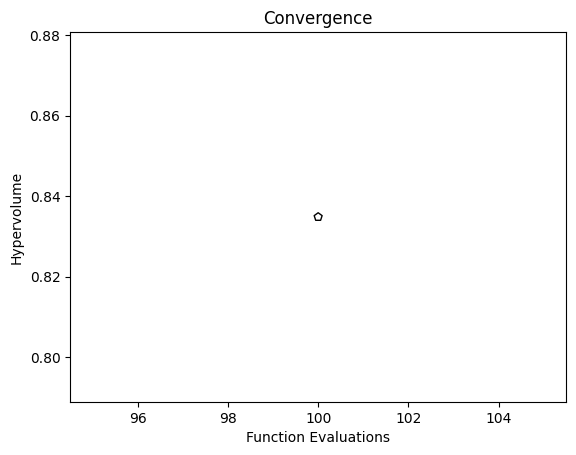

In [37]:
start = time.time()
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 1), # number of iteration for eval problem class
			    verbose=True)
print(time.time() - start)
plotSingleResult(res)

In [ ]:
plotSingleResult(res)

In [ ]:
mean = []
for result in [res]:
    for solution in result.X:
        mean.extend((np.array(list(go_completeness.values()))[solution]))

np.array(mean).mean()

### Roda Comparação

In [ ]:
result_stock = []
result_modified = []

for i in tqdm(range(1)):
    algorithm = NSGA2(pop_size=100,
				  sampling=BinaryDistributedPathwaysSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimited(),
                  save_history = True)
    
    res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 1), # number of iteration for eval problem class
			    copy_algorithm=False,
                verbose=True)
    
    algorithm.termination = MaximumGenerationTermination(100)

    problem_ = GeneSelection(X,y.values, runner_)
    checkpoint = copy.deepcopy(algorithm)
    checkpoint.problem = problem_
    checkpoint.mating.mutation = BitflipMutationLimitedGuided()
    
    res = minimize(problem,
                   algorithm,
                   ("n_gen", 100),
                   copy_algorithm=False,
                   verbose=True,
                   save_history = True)
    res_ = minimize(problem_,
                   checkpoint,
                   ("n_gen", 100),
                   copy_algorithm=False,
                   verbose=True,
                   save_history = True)

    result_stock.append(res)
    result_modified.append(res_)

############################################################################

In [41]:
def plot_convergence(res, color):
    n_evals = np.array([e.evaluator.n_eval for e in res.history])
    opt = np.array([e.opt[0].F for e in res.history])
    
    X_res, F_res = res.opt.get("X", "F")
    
    hist = res.history
    max = 15
    ref_point = np.array([max, -0.75])
    ind = HV(ref_point=ref_point)
    
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    
    for algo in hist:
        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)
    
        # retrieve the optimum from the algorithm
        opt = algo.opt
    
        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())
    
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    
    metric = HV(ref_point= ref_point,
                         norm_ref_point=True)

    hv = [metric.do(_F)/5 for _F in hist_F]

    plt.plot(n_evals, hv,  color='black', lw=0.3, label="Avg. CV of Pop", alpha = 1)
    plt.scatter(n_evals, hv,  facecolor="none", edgecolor=color, marker="p", linewidths=0.5, alpha = 1)
    plt.title("Convergence")
    plt.xlabel("Function Evaluations")
    plt.ylabel("Hypervolume")
    #for i in range(20):
    #    plt.axvline(x=200*i, color='r', linestyle='--', linewidth=0.7)
    #plt.xscale(value = 'log')
    #plt.show()
    return ind(F_res)/5


def plotComparisonConvergence(results_stock, results_cancer_pathways, results_breast_cancer_pathways):
    plt.figure(figsize=(16,6))
    media_stock = []
    
    for res in results_stock:
        media_stock.append(plot_convergence(res, 'blue'))
    media_cancer = []
    for res in results_cancer_pathways:
        media_cancer.append(plot_convergence(res, 'red'))
    media_breast_cancer = []
    for res in results_breast_cancer_pathways:
        media_breast_cancer.append(plot_convergence(res, 'green'))
    
    print(np.array(media_stock).sum()/len(results_stock))
    print(np.array(media_cancer).sum()/len(results_stock))    
    print(np.array(media_breast_cancer).sum()/len(results_stock))
    

In [42]:
max = 15
ref_point = np.array([max, -0.75])
metric = HV(ref_point= ref_point,
                         norm_ref_point=False)
def calculate_mean_std(results):
    hypervolumes = []
    for result in results:
        hypervolumes.append(metric.do(result.opt.get("F"))/5)
    print("Mean: ",np.array(hypervolumes).mean())
    print("STD: ",np.array(hypervolumes).std())

calculate_mean_std(results_stock)
calculate_mean_std(results_cancer_pathways)
calculate_mean_std(results_breast_cancer_pathways)


Mean:  0.15399999999999997
STD:  0.01457504716973501
Mean:  0.14463999999999996
STD:  0.01898184395679199
Mean:  0.14516000000000004
STD:  0.02658673353385101


In [43]:
def count_features(results):
    all_features = []
    for result in results:
        for x in result.X:
            all_features.extend(np.array(colunas)[x])
    print(len(set(all_features)))

count_features(results_stock)
count_features(results_cancer_pathways)
count_features(results_breast_cancer_pathways)

774
383
546


In [ ]:
np.array(range(len(results_cancer_pathways[1].X[1])))[results_cancer_pathways[1].X[3]]

0.15399999999999997
0.14463999999999996
0.14516000000000004


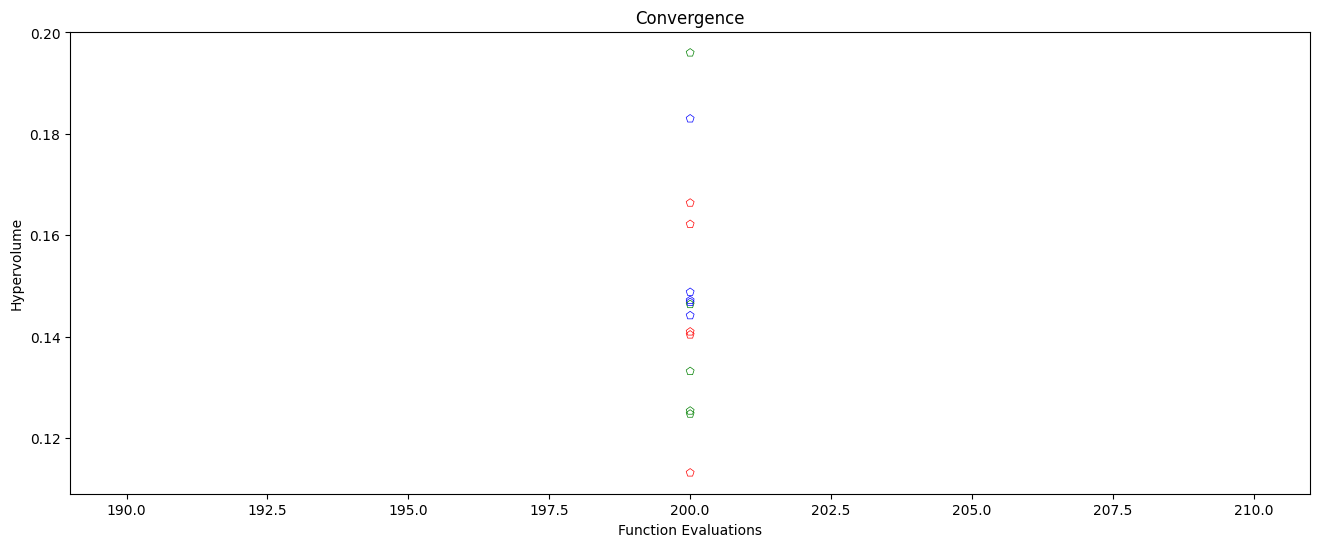

In [45]:
plotComparisonConvergence(results_stock, results_cancer_pathways, results_breast_cancer_pathways)

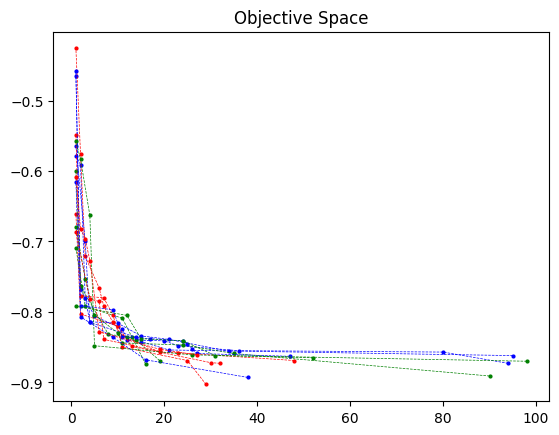

In [44]:
def plot_pareto_front(res, color):
    #plt.figure(figsize=(7, 5))
    X_res, F_res = res.opt.get("X", "F")
    plt.plot(F_res[:, 0][np.argsort(F_res[:, 1])], F_res[:, 1][np.argsort(F_res[:, 1])], color = color,  marker='o', mfc=color, mec=color, ms=2, ls='--', lw=0.5, zorder=2)
    plt.title("Objective Space")

for (i,j,k) in zip(results_stock, results_cancer_pathways ,results_breast_cancer_pathways):
    plot_pareto_front(i, 'blue')
    plot_pareto_front(j, 'red')
    plot_pareto_front(k, 'green')



In [46]:
results_stock = []
results_cancer_pathways = []
results_breast_cancer_pathways = []

pop_size = 200
n_gen = 1
for i in tqdm(range(50)):
    algorithm = NSGA2(pop_size=pop_size,
				  sampling=BinaryDistributedRandomSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedBalanced(go_completeness = None),
                  save_history = True)
    
    res_stock = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", n_gen), # number of iteration for eval problem class,
                verbose=True)
    
    algorithm = NSGA2(pop_size=pop_size,
				  sampling=BinaryDistributedPathwaysSampling(go_completeness = np.maximum(np.array(list(go_completeness.values())), 0)),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedBalanced(go_completeness = np.maximum(np.array(list(go_completeness.values())), 0)),
                  save_history = True)
    
    res_cancer_pathways = minimize(problem,
                   algorithm,
                   ("n_gen", n_gen),
                   verbose=True)

    algorithm = NSGA2(pop_size=pop_size,
				  sampling=BinaryDistributedPathwaysSampling(go_completeness = np.maximum(np.array(list(go_completeness.values())), 0.5)),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedBalanced(go_completeness = np.maximum(np.array(list(go_completeness.values())), 0.1)),
                  save_history = True)
    
    res_breast_cancer_pathways = minimize(problem,
                   algorithm,
                   ("n_gen", n_gen),
                   verbose=True)

    results_stock.append(res_stock)
    results_cancer_pathways.append(res_cancer_pathways)
    results_breast_cancer_pathways.append(res_breast_cancer_pathways)

############################################################################

  0%|          | 0/50 [00:00<?, ?it/s]

[1, 1, 1, 2, 3, 3, 4, 5, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 15, 15, 15, 15, 16, 17, 17, 17, 18, 18, 18, 19, 20, 20, 20, 20, 21, 21, 23, 24, 24, 24, 25, 27, 27, 27, 29, 29, 29, 31, 31, 32, 32, 32, 33, 33, 33, 33, 33, 35, 36, 36, 37, 38, 39, 39, 40, 41, 42, 43, 43, 43, 44, 44, 45, 46, 46, 46, 46, 47, 47, 47, 48, 50, 50, 50, 51, 51, 51, 52, 52, 53, 53, 53, 54, 54, 54, 55, 56, 58, 58, 59, 59, 60, 61, 61, 63, 64, 64, 64, 65, 65, 66, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 71, 71, 72, 72, 72, 72, 74, 75, 76, 77, 78, 79, 79, 79, 79, 80, 80, 81, 81, 81, 81, 82, 82, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 84, 84, 85, 85, 85, 87, 87, 87, 87, 88, 88, 89, 89, 90, 90, 90, 91, 93, 93, 94, 94, 95, 95, 95, 95, 95, 96, 97, 98, 98, 98, 99]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      9 |             - |             -
[1, 1, 2, 2, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 

In [ ]:
with open('Data/results.pkl', 'wb') as file:
    pickle.dump([results_stock, results_cancer_pathways, results_breast_cancer_pathways], file)

In [ ]:
results = pickle.load(open('Data/results.pkl', 'rb'))

In [ ]:
mean = []
for result in results_stock:
    for solution in result.X:
        mean.extend((np.array(list(go_completeness.values()))[solution]))

np.array(mean).mean()

In [ ]:
results_stock[0].X

In [ ]:
go_completeness